In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps

# **EQUATION  DEFINITION**

In this section, we define the physics of the system. We are modeling a Forced LC Circuit (Inductor-Capacitor circuit driven by an external voltage). Mathematically, this behaves like a forced harmonic oscillator.

$$\frac{dI}{dt} = -\omega_0^2 Q + \frac{V_0}{L}\cos(\omega_f t)$$


The code below establishes these parameters and defines the function forced_lc_system. All for later generate the data 


In [3]:
#Equation parameters 

# Parámetros basados en tu ecuación
omega_0 = 5.0      # Natural frequency (rad/s)
omega_f = 7.0      # Force frequency (rad/s)
V0_L = 10.0        # Force Amplitude (V0 / L) 



#System function
def forced_lc_system(t, y, u_func):
    Q = y[0]
    I = y[1]
    
    #Forcing singnal at time t
    forcing = u_func(t)
    
    dQ_dt = I
    dI_dt = -(omega_0**2) * Q + forcing
    
    return [dQ_dt, dI_dt]


#Force frecuency
def forcing_signal(t):
    return V0_L * np.cos(omega_f * t)


# **DATA GENERATION**

Here, we simulate the circuit to generate synthetic training data. In a real-world scenario, this data would come from sensors measuring charge and current over time.
We use a numerical integrator (scipy.integrate.solve_ivp) to solve the system defined in the previous section.
- Time Span:We simulate 10 seconds of activity with a resolution ($dt$) of 0.01 seconds.
- Initial Conditions: We start the system with an initial charge $Q_0 = 2.0$ and zero current $I_0 = 0.0$.
- Control Input ($U$): To help SINDy distinguish between internal dynamics and external forces, we must also provide the forcing signal array, $U(t) = \frac{V_0}{L}\cos(\omega_f t)$, as a separate input.
- The output X_train is a matrix where the first column is $Q$ and the second is $I$.

In [4]:
dt = 0.01
t_train = np.arange(0, 10, dt)
initial_conditions = [2.0, 2.0]  # Q Initial=2, I Initial=0

# Solve the system to generate training data
sol = solve_ivp(
    fun=lambda t, y: forced_lc_system(t, y, forcing_signal),
    t_span=[t_train[0], t_train[-1]],
    y0=initial_conditions,
    t_eval=t_train
)

X_train = sol.y.T  # State matrix [n_samples, 2]

# Create the control input vector u(t) for SINDy
U_train = forcing_signal(t_train).reshape(-1, 1) 

print(f"Data generated: {X_train.shape} samples.")


Data generated: (1000, 2) samples.


# **SINDy TRAINING**

This is the core of the notebook where we apply Sparse Identification of Nonlinear Dynamics (SINDy). SINDy attempts to find the governing equations of a system by selecting the fewest possible terms from a library of candidate functions that best fit the data derivatives.The training process involves three key components:
- Feature Library (PolynomialLibrary): We define a candidate library of functions. Since an LC circuit is a linear system, we set degree=1 to look for linear relationships.
- Optimizer (STLSQ): We use Sequential Thresholded Least Squares. This optimizer fits the data but iteratively "zeros out" coefficients smaller than the threshold=0.1. This enforces sparsity, ensuring the resulting model is simple and interpretable (Occam's Razor).
- Model Fitting: The model.fit command takes the state data $X$ and the forcing control $U$ to solve for the coefficient matrix $\Xi$ in the equation:$$\dot{X} \approx \Theta(X, U)\Xi$$

In [5]:

#Define equation library (linear terms only)
poly_library = ps.PolynomialLibrary(degree=1, include_bias=False)

#Optimize (Sequential Thresholded Least Squares)
optimizer = ps.STLSQ(threshold=0.1)

model = ps.SINDy(
    feature_library=poly_library,
    optimizer=optimizer,
)

# Train the model. 
# U = Force input
model.fit(x=X_train, t=dt, u=U_train)





,optimizer,STLSQ()
,feature_library,PolynomialLib...de_bias=False)
,differentiation_method,FiniteDifference()
,discrete_time,False
,degree,1
,include_interaction,True
,interaction_only,False
,include_bias,False
,order,'C'
,threshold,0.1
,alpha,0.05


# **MODEL RESULTS**

In this final section, we validate the AI's discovery. We take the equation discovered by SINDy and use it to simulate the system forward in time, starting from the same initial conditions.

We then plot two lines:

- Black Dashed Line: The "Real" data generated by the numerical solver given by the equations.

- Red Line: The trajectory predicted by the SINDy model.

**Conclusion:**  the red line perfectly overlay the black dashed line. This confirms that the algorithm successfully recovered the differential equations purely from data, without being explicitly programmed with the laws of physics.




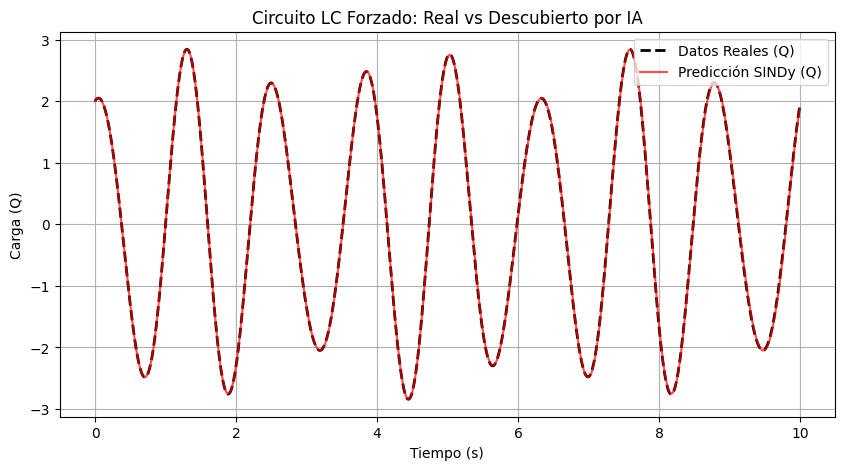

In [6]:

#Simulate the model with the initial conditions and forcing signal
X_sim = model.simulate(initial_conditions, t_train, u=forcing_signal)


#GRAPHICS
plt.figure(figsize=(10, 5))
plt.plot(t_train, X_train[:, 0], 'k--', label='Datos Reales (Q)', linewidth=2)
plt.plot(t_train, X_sim[:, 0], 'r', label='Predicción SINDy (Q)', alpha=0.7)
plt.title(f'Circuito LC Forzado: Real vs Descubierto por IA')
plt.xlabel('Tiempo (s)')
plt.ylabel('Carga (Q)')
plt.legend()
plt.grid(True)
plt.show()